## 1. Implementation 

Your goal is given $G=(V,E)$ and an integer $k$ to find a set of $S$ nodes so that the **expected spread of influence** from $S$ under the independent cascade model, denoted by $F(S)$ is maximized.

Assume that information propagates using the independent cascade model, where for each edge $(u,v)$: $p_{uv}=p_{vu}=\frac{1}{2}$.

Remember you can find the paper here:
https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf

For the experiments in this part you are going to use the graph available here (LastFM Asia network): 
https://snap.stanford.edu/data/feather-lastfm-social.html

## 1.1 

Implement the greedy algorithm in order to maximize F(S). In order to implement this algorithm you need to sample $N$ graphs (by sampling the edges according to their probabilities) and find the connected components of the corresponding sampled graphs.

In [ ]:
import networkx as nx
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
from heapq import heappop, heappush, heapify
import time
import numpy as np

In [ ]:
df = pd.read_csv('lastfm_asia_edges.csv')
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(df, source = 'node_1', target = 'node_2', edge_attr = None, create_using=Graphtype)

In [ ]:
def graph_sampling(G):
    
    graph_samples = []
    for i in range(100): # Sample the original graph hundred times
        A = G.copy()
        for edge in G.edges:
            if np.random.uniform(low=0.0, high=1.0, size=None) < 0.5:
                A.remove_edge(edge[0], edge[1])
        graph_samples.append(A)
    
    return graph_samples

graph_samples = graph_sampling(G)

In [ ]:
list_ = [] # To store details about the samples
for i in range(100):
    list_.append(list(nx.connected_components(graph_samples[i])))

In [ ]:
def F_S(S, graph_samples):
    
    nodes_activated = 0
    
    for i in range(100):
        cc_length = 0
        nodes_visited = [] # Keeps track of nodes already activated
        for node in S:
            if node not in nodes_visited:
                for cluster in list_[i]:
                    if node in cluster:
                        nodes_visited.extend(cluster) 
                        cc_length += len(cluster)
                        break
        nodes_activated += cc_length

    return nodes_activated

In [ ]:
def greedy_algorithm(G, k, graph_samples):
    
    S = set()
    A = G.copy()
    
    for iterations in range(k):
        
        # Calculate F(S)
        F_S_ = F_S(S, graph_samples)
                    
        max_marginal_gain = -1
        selected_node = -1
        
        # Find F_S_e for all nodes currently remaining
        for remaining_node in A.nodes:
            S.add(remaining_node) # Add node to S
            F_S_e = F_S(S, graph_samples)
                        
            # Calculate marginal gain
            marginal_gain = F_S_e - F_S_
            
            if marginal_gain > max_marginal_gain:
                max_marginal_gain = marginal_gain
                selected_node = remaining_node
                
            S.discard(remaining_node) # Remove node from S
            
        # Add selected node to S
        S.add(selected_node)
        A.remove_node(selected_node)
        
    return S

## 1.2 


Implement the "lazy" greedy algorithm of the above version of greedy and plot the performande (in terms of $F(S)$) of each algorithm as a function of $k$. (they should be identical). 

In a different plot, plot the running time of greedy and lazy greedy as a function of $k$.

In [ ]:
def lazy_greedy_algorithm(G, k, graph_samples):
    
    S = set()
    heap = []
    heapify(heap)
    
    #Store all marginal gains w.r.t the empty set
    for node in G.nodes:
        marginal_gain = F_S([node], graph_samples)
        heappush(heap, (-1 * marginal_gain, node))
    
    S.add(heappop(heap)[1])
    
    for iterations in range(1, k):
        max_node = heappop(heap)[1]
        second_max_node_gain =  -1 * heap[0][0]
      
        # Compute marginal gain of max_node
        F_S_0 = F_S(S, graph_samples)
        S.add(max_node)
        F_S_1 = F_S(S, graph_samples)
        S.discard(max_node)
        marginal_gain = F_S_1 - F_S_0

        # Comparison
        if marginal_gain >= second_max_node_gain:
            S.add(max_node)
    
        else:
            heappush(heap, (-1 * marginal_gain, max_node))
            selected_node = -1
            
        while(selected_node == -1):
            first_node = heappop(heap)[1]
            second_node_gain =  -1 * heap[0][0]
        
            # Compute marginal gain of first_node
            F_S_0 = F_S(S, graph_samples)
            S.add(first_node)
            F_S_1 = F_S(S, graph_samples)
            marginal_gain = F_S_1 - F_S_0
            S.discard(first_node)

            # Comparison
            if marginal_gain >= second_node_gain:
                selected_node = first_node  
            else:
                heappush(heap, (-1 * marginal_gain, first_node))
          
        S.add(selected_node)
            
    return S

In [ ]:
greedy_values = []
lazy_greedy_values = []
greedy_times = []
lazy_greedy_times = []
for k in range(1, 11):
    start = time.time()
    S = greedy_algorithm(G, k, graph_samples)
    greedy_times.append(time.time() - start)
    greedy_values.append(F_S(S, graph_samples))
    start = time.time()
    S = lazy_greedy_algorithm(G, k, graph_samples)
    lazy_greedy_times.append(time.time() - start)
    lazy_greedy_values.append(F_S(S, graph_samples))

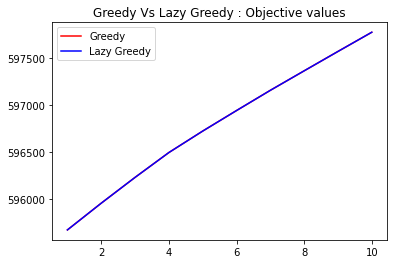

In [ ]:
plt.plot(range(1, 11), greedy_values, color = 'red', label = "Greedy")
plt.plot(range(1, 11), lazy_greedy_values, color = 'blue', label = "Lazy Greedy")
plt.legend(loc="upper left")
plt.title("Greedy Vs Lazy Greedy : Objective values")
plt.show()

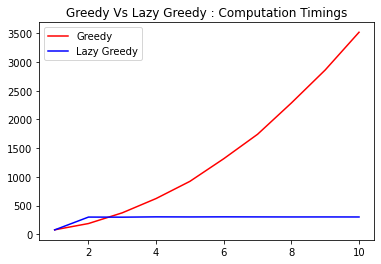

In [ ]:
plt.plot(range(1, 11), greedy_times, color = 'red', label = "Greedy")
plt.plot(range(1, 11), lazy_greedy_times, color = 'blue', label = "Lazy Greedy")
plt.legend(loc="upper left")
plt.title("Greedy Vs Lazy Greedy : Computation Timings")
plt.show()

## 1.3 Comparison with baselines 


Implement the "degree" baseline that picks nodes according to their degree in the original graph.


Plot the value $F(S)$ of the solution achieved by lazy greedy and degree as a function of $k$.

In [ ]:
def degree_algorithm(G, k):
    
    S = set()
    top_k = sorted(G.degree, key=lambda x: x[1], reverse=True)[:k]
    for element in top_k:
        S.add(element[0])
    return S

In [ ]:
degree_values = []
for k in range(1, 11):
    S = degree_algorithm(G, k)
    degree_values.append(F_S(S, graph_samples))

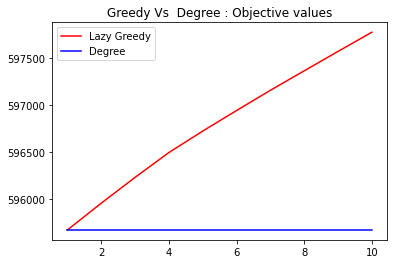

In [ ]:
plt.plot(range(1, 11), lazy_greedy_values, color = 'red', label = "Lazy Greedy")
plt.plot(range(1, 11), degree_values, color = 'blue', label = "Degree")
plt.legend(loc="upper left")
plt.title("Greedy Vs  Degree : Objective values")
plt.show()

The degree algorithm selects nodes from the same connected components each time and hence only the nodes in the connected component are activated even as k keeps on increasing.